<a href="https://colab.research.google.com/github/RobertoRamosCastro/ImageClassification/blob/main/CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras 
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

print("keras version", keras.__version__)

keras version 2.11.0


In [ ]:
# Cargar base de datos de diferentes tipos de fuentes
import os 
from six.moves import urllib

file_url = 'https://github.com/bloolizard/PlayWithTensorFlow/raw/master/data_with_labels.npz'
file_name = 'data_with_labels.npz'

if not os.path.exists(file_name):
  urllib.request.urlretrieve(file_url, file_name)

# Cargar datos
data = np.load(file=file_name)

train= data['arr_0'] / 255
labels= data['arr_1']

onehot = to_categorical(labels, num_classes=len(np.unique(labels)))

In [ ]:
#train.shape
labels

array([0, 0, 0, ..., 4, 4, 4], dtype=uint8)

In [ ]:
# Dividir datos de entrenamineto al 90% y el resto para validacion
np.random.seed(100)

indices = np.random.permutation(train.shape[0])

valid_cnt = int(train.shape[0] * 0.1)

test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
  
test, train = train[test_idx,:],\
              train[training_idx,:]
  
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]
train=train.reshape([-1,train.shape[1],train.shape[2],1])
test=test.reshape([-1,test.shape[1],test.shape[2],1])

print('Forma de datos de Entrenamiento=', train.shape , '\nForma de datos de Test=', test.shape)


Forma de datos de Entrenamiento= (2511, 36, 36, 1) 
Forma de datos de Test= (279, 36, 36, 1)


In [ ]:
# Cargando nuevo set de datos para la misma arq de CNN
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
data, metadata = tfds.load('cifar10', as_supervised=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete13GUM2/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete13GUM2/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [114]:
train, test = data['train'], data['test']

In [115]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [116]:
class_names = metadata.features['label'].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [117]:
# Normalizar la data

def normalize(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, dtype=tf.float32)
  imagenes /= 255
  return imagenes, etiquetas

train = train.map(normalize)
test = test.map(normalize)

# Cargarlo en la memoria de cache
train = train.cache()
test = test.cache()


In [118]:
# Preprocesamiento de los datos
BATCH_SIZE = 32
train = train.shuffle(metadata.splits['train'].num_examples)
train = train.batch(BATCH_SIZE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

In [119]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

TypeError: ignored

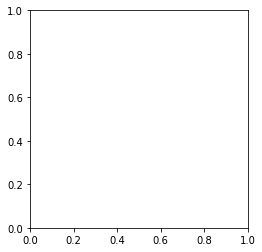

In [106]:
import matplotlib.pyplot as plt

for imagen, lbl, in train.take(1):
  break
  imagen = imagen.numpy().reshape((28,28)) # Redimensionamos

# Dibujar la imagen
plt.figure()
plt.imshow(imagen)
plt.colorbar()
plt.grid(False)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

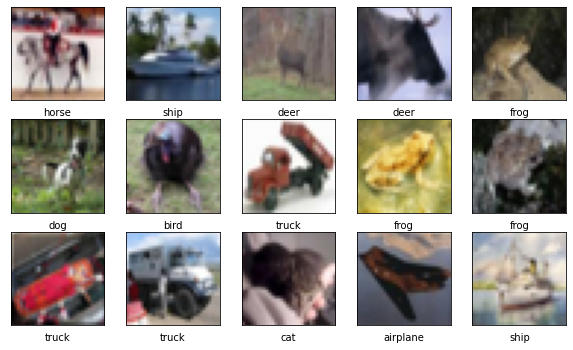

In [ ]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(train.take(15)):
  imagen = imagen.numpy()
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(class_names[etiqueta])
plt.show

In [120]:
ds = tfds.load('cifar10', split='train')
ds = ds.take(1)

for example in ds:
  print(list(example.keys()))
  image = example['image']
  tamano_entrada = image.shape
  label = example['label']
  print(tamano_entrada, label)

['id', 'image', 'label']
(32, 32, 3) tf.Tensor(7, shape=(), dtype=int64)


In [121]:
# Definir la arquitectura de nuestra CNN
from keras.layers.merging.add import add
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten, Dropout
from keras import Input

num_clases = len(class_names)

model = Sequential()

# Hidden layer 1
model.add(Convolution2D(4, (5,5), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden layer 2
model.add(Convolution2D(4, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_clases, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 4)         304       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 4)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 4)         404       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 4)          0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 32)              

In [122]:
# Definir modelo

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
# Entrenar modelo

history = model.fit(train,
          epochs=100,
          batch_size=BATCH_SIZE,
          validation_data=test,
          verbose=2)

Epoch 1/100


ValueError: ignored

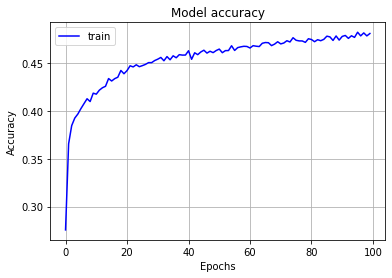

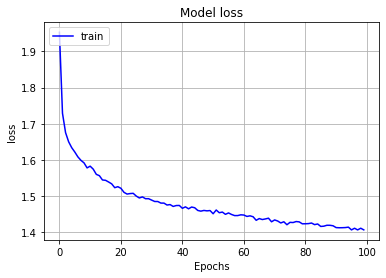

In [99]:
# Graficar modelo
loss = history.history['loss']
accuracy = history.history['accuracy']

plt.plot(accuracy, 'b-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

plt.plot(loss, 'b-')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()


In [100]:
# Accuracy maxima
max_acc = max(val_accuracy)
print('Val_accuracy maxima:',max_acc)

max_loss = max(val_loss)
print('Val_loss maxima:',max_loss)

NameError: ignored

In [ ]:
# Guardar modelo 
model.save('ruta/a/guardar/tu/modelo.h5')

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

Arial-fuente.png  data_with_labels.npz	gdrive	sample_data


In [ ]:
# Prediccion

import keras
import numpy as np
import cv2

# Cargar modelo guardado
#model = keras.models.load_model('ruta/a/tu/modelo.h5')

# Cargar datos para predecir
img = cv2.imread('3923.jpg', cv2.IMREAD_GRAYSCALE)

# Asegurarnos de que la imagen tenga el tamaño adecuado
img = cv2.resize(img, (36, 36))

# Convertir imagen a matriz numpy y normalizar valores de pixel
X_pred = np.array([img])
X_pred_norm = X_pred / 255.0

# Realizar predicción
y_pred = model.predict(X_pred_norm)

# Obtener etiqueta predicha
label_pred = np.argmax(y_pred)

# Imprimir etiqueta predicha
print("La etiqueta predicha es:", label_pred)



1/1 [==============================] - 0s 23ms/step
La etiqueta predicha es: 3
